In [1]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import subprocess
import scipy as sc
from itertools import product

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.figsize": (4, 3.5),
    "text.latex.preamble": "\n".join([
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[T1]{fontenc}",
        r"\usepackage[detect-all,locale=FR]{siunitx}",
    ]),
    'lines.markersize': 10,
    'lines.color': 'grey',
    'scatter.marker': '+',
    'errorbar.capsize': 3,
    'savefig.bbox': 'tight',
})

In [2]:
path = '../'
executable = 'bin/ex2'
export_path = path + 'rapport/figures/'
data_path = 'data/'
config_path = 'bin/'
config_name = 'chaos2'
config_ext = '.conf'

In [3]:
def stringify_dict(d: dict, sep=',') -> str:
    return sep.join(map(lambda a: str(a[0]) + "=" + str(a[1]), tuple(d.items())))

In [4]:
def run(config_file: str, output_file: str, params: dict = {}) -> None:
    # print(f"Running with config file {config_file}")
    options = stringify_dict(params, sep=' ')
    cmd = f"{path}{executable} {path}{config_file} output='{path}{output_file}' {options}"
    print(f"Running command `{cmd}`")
    subprocess.run(cmd, shell=True, stdout=subprocess.DEVNULL)
    # print("Done")

In [5]:
def load_conf() -> dict:
    conf = {}
    with open(path + config_path + config_name + config_ext, 'r') as f:
        lines = f.read().split('\n')

    for line in lines:
        if not line:
            continue
        name, _, val, *_ = line.split(' ')
        name = name.strip()
        val = val.strip()
        try:
            conf[name] = float(val)
        except ValueError:
            conf[name] = val
    
    return conf

In [6]:
nsteps = np.array([2000])
nsimul = len(nsteps)  # Number of simulations to perform

conf = load_conf()

omega0 = np.sqrt(conf['g']/conf['L'])
2*omega0

14.007141035914502

In [7]:
%%bash
cd .. && make clean && make

clang++ -o bin/ex2 src/Ex2_2024_student.cpp -std=c++17 -Wall -Wextra -O2 


In [8]:
# params_variations = {
#     'nsteps': nsteps,
# }
# all_params = tuple(
#     {a: b for a, b in zip(params_variations.keys(), c)} for c in product(*params_variations.values())
# )

all_params = (
    {'theta0': 0, 'thetadot0': 15},
    {'theta0': 1e-6, 'thetadot0': 15},
)

# Run simulations
outputs = []  # List to store output file names
for params in all_params:
    output_file = f"{data_path}{config_name},{stringify_dict(params)}.out"
    outputs.append(output_file)
    run(f'{config_path}{config_name}{config_ext}', output_file, params)

Running command `../bin/ex2 ../bin/chaos2.conf output='../data/chaos2,theta0=0,thetadot0=15.out' theta0=0 thetadot0=15`
Running command `../bin/ex2 ../bin/chaos2.conf output='../data/chaos2,theta0=1e-06,thetadot0=15.out' theta0=1e-06 thetadot0=15`


In [9]:
# Load stuff in memory
all_data = {}

for file, params in zip(outputs, all_params):
    data = np.loadtxt(path + file)
    all_data[file] = (params, np.copy(data))

# Plots!

[ 0.57622074 -5.81641607]


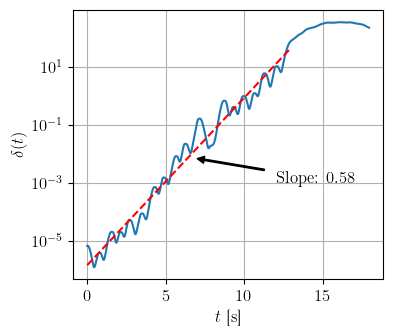

In [10]:
datas1 = all_data[outputs[0]][1]
datas2 = all_data[outputs[1]][1]
t = datas1[:,0]

delta = np.sqrt(
    omega0**2
    * (datas1[:,1] - datas2[:,1])**2
    + (datas1[:,2] - datas2[:,2])**2
)
plt.semilogy(t, delta)

idx = np.where(t < 12)[0]
# plt.axvline(t[idx[-1]])
coefs = np.polyfit(t[idx], np.log10(delta[idx]), 1)
print(coefs)
fitfunc = np.poly1d(coefs)
ts = t[:idx[-1]+200]
plt.annotate(
    r'Slope: {:.2f}'.format(coefs[0]),
    xy=(ts[len(ts)//2], 10**fitfunc(ts[len(ts)//2])),
    xytext=(12, 1e-3),
    arrowprops=dict(
        facecolor='black',
        width=1,
        headwidth=5,
        headlength=5,
        shrink=0.1
    ),
    # horizontalalignment='left',
    # verticalalignment='center_baseline',
)

plt.semilogy(ts, 10**(fitfunc(ts)), 'r--')
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'$\delta (t)$')
plt.grid()
plt.savefig(export_path + 'lyapounov.pdf')